In [ ]:
%matplotlib inline
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import gym
from gym import logger as gymlogger
import base64
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
class DQN_MountainCar(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
         
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=64)   
        self.fc2 = nn.Linear(in_features=64, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=3)            

    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

Transition = namedtuple('transition',('state', 'action', 'next_state', 'reward'))

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

class EpsilonGreedy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

class Agent():
    def __init__(self, method, num_actions, device):
        self.current_step = 0
        self.num_actions = num_actions
        self.device = device
        self.method = method

    def select_action(self, state, policy):
        rate = self.method.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device)    
        else:
            with torch.no_grad():
                return policy(state).argmax(dim=1).to(self.device)

In [ ]:
class MountainCarManager():
    def __init__(self, device):
        self.device = device
        self.env = wrap_env(gym.make('MountainCar-v0'))
        self.env.reset()
        self.CurrScreen = None
        self.done = False
    
    def reset(self):
        self.env.reset()
        self.CurrScreen = None
        
    def close(self):
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)

    def getState(self):
        if self.isStartingScreen() or self.done:
            self.CurrScreen = self.processedScreen()
            black_screen = torch.zeros_like(self.CurrScreen)
            return black_screen
        else:
            screen1 = self.CurrScreen
            screen2 = self.processedScreen()
            self.CurrScreen = screen2
            return screen2 - screen1


    def availableActions(self):
        return self.env.action_space.n
        
    def takeAction(self, action):        
        next_state, reward, self.done, _ = self.env.step(action.item())
        return next_state, torch.tensor([reward], device=self.device)

    def getHeightOfScreen(self):
        screen = self.processedScreen()
        return screen.shape[2]
    
    def getWidth(self):
        screen = self.processedScreen()
        return screen.shape[3]
       
    def processedScreen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1))
        return self.screenValidTransformation(screen)

    def isStartingScreen(self):
        return self.CurrScreen is None
    
    
    def screenValidTransformation(self, screen):       
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        resize = T.Compose([T.ToPILImage(),T.Resize((60,100)),T.ToTensor()])
        
        return resize(screen).unsqueeze(0).to(self.device) 

In [ ]:
def getTensors(experiences):
    # Convert batch of Transitions to Transition of batches
    batch = Transition(*zip(*experiences))

    state = torch.cat(batch.state)
    action = torch.cat(batch.action)
    reward = torch.cat(batch.reward)
    next_state = torch.cat(batch.next_state)

    return (state,action,reward,next_state)


class findQVals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    @staticmethod
    def getCurr(policy, states, actions):
        return policy(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod    
    def getNextState(target, next_states):                
        finalStates = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        nonFinal = (finalStates == False)
        non_final_states = next_states[nonFinal]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(findQVals.device)
        values[nonFinal] = target(non_final_states).max(dim=1)[0].detach()
        return values


def getReward(location, velocity):
  reward = 0
  if location > 0.51:
    reward += 2500
  if location > 0.501:
    reward += 2000
  if location > 0.5:
    reward += 1000
  if location > 0.45:
    reward += 200
  if location > 0.4:
    reward += 70
  if location > 0.3:
    reward += 15
  if location > 0.1:
    reward += 7
  if location > -0.1:
    reward += 4
  if location > -0.3:
    reward += 2
  if location > -0.4:
    reward += 0.5


  if abs(velocity) > 0.03:
    reward += 15
  if abs(velocity) > 0.02:
    reward += 10
  if abs(velocity) < 0.005:
    reward -= 6

  return reward

In [ ]:
batch_size = 512
gamma = 0.97
epsilonStart = 1
epsilonEnd = 0.02
epsilonDecay = 0.001
targetUpdate = 10
memory_size = 100000
lr = 0.002
num_episodes = 1300 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
em = MountainCarManager(device)
strategy = EpsilonGreedy(epsilonStart, epsilonEnd, epsilonDecay)
agent = Agent(strategy, em.availableActions(), device)
memory = ReplayMemory(memory_size)
policy = DQN_MountainCar(em.getHeightOfScreen(), em.getWidth()).to(device)
target = DQN_MountainCar(em.getHeightOfScreen(), em.getWidth()).to(device)
target.load_state_dict(policy.state_dict())




target.eval()
optimizer = optim.Adam(params=policy.parameters(), lr=lr)
maxRightValues = []
episode_rewards = []
episodeNum = []
trainingTime = time.time()
for episode in range(num_episodes):
    em.reset()
    state = em.getState()
    episodeReward = 0
    maxRight = -1.2

    for timestep in count():
        action = agent.select_action(state, policy)
        tempState, reward = em.takeAction(action)
        next_state = em.getState()
        reward = getReward(tempState[0],tempState[1])
        right = tempState[0]
        episodeReward += reward

        if maxRight < right:
          maxRight = right
          if maxRight >= 0.5:
            print("EPISODE WON", episode)
        reward = torch.tensor([reward], device=device)
        memory.push(Transition(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = getTensors(experiences)
            
            currentQ = findQVals.getCurr(policy, states, actions)
            nextQ = findQVals.getNextState(target, next_states)
            targetQ = (nextQ * gamma) + rewards

            loss = F.mse_loss(currentQ, targetQ.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            episodeNum.append(timestep)
            break

    print("Episode: ", episode, "Max Right: ", round(maxRight, 3), "Reward: ", round(episodeReward,3))
    maxRightValues.append(maxRight)
    episode_rewards.append(episodeReward)
    if episode % targetUpdate == 0:
        target.load_state_dict(policy.state_dict())
        
em.close()
trainingTime = time.time() - trainingTime

cuda:0
Episode:  0 Max Right:  -0.342 Reward:  -259.0
Episode:  1 Max Right:  -0.478 Reward:  -858
Episode:  2 Max Right:  -0.306 Reward:  67.5
Episode:  3 Max Right:  -0.173 Reward:  360.0
Episode:  4 Max Right:  -0.366 Reward:  -415.0
Episode:  5 Max Right:  -0.169 Reward:  618.0
Episode:  6 Max Right:  -0.331 Reward:  -270.0
Episode:  7 Max Right:  -0.198 Reward:  111.0
Episode:  8 Max Right:  -0.223 Reward:  24.0
Episode:  9 Max Right:  -0.214 Reward:  77.5
Episode:  10 Max Right:  -0.224 Reward:  214.5
Episode:  11 Max Right:  -0.139 Reward:  67.5
Episode:  12 Max Right:  -0.141 Reward:  471.5
Episode:  13 Max Right:  -0.168 Reward:  814.0
Episode:  14 Max Right:  -0.089 Reward:  1421.0
Episode:  15 Max Right:  -0.127 Reward:  1168.5
Episode:  16 Max Right:  -0.088 Reward:  1282.5
Episode:  17 Max Right:  -0.063 Reward:  1504.0
Episode:  18 Max Right:  0.079 Reward:  1746.0
Episode:  19 Max Right:  -0.064 Reward:  1268.0
Episode:  20 Max Right:  -0.024 Reward:  1171.0
Episode:  21

In [ ]:
print("Total Time to train this model: ", round(trainingTime / 60, 3), "Minutes")

Total Time to train this model:  88.18296356201172 Minutes


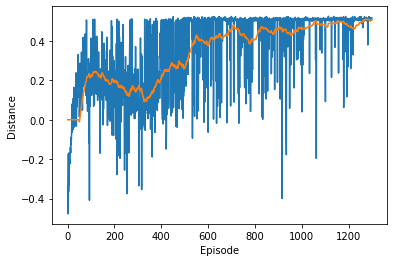

In [ ]:
plt.figure(1)
plt.clf()
plt.title('Episode v. Distance')
plt.xlabel('Episode')
plt.ylabel('Distance')
distance = [x for x in maxRightValues] 
maxRightValues_Tensor = torch.tensor(distance, dtype=torch.float)
plt.plot(maxRightValues_Tensor.numpy())
if len(maxRightValues_Tensor) >= 50:
    means = maxRightValues_Tensor.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(50), means))
    plt.plot(means.numpy())

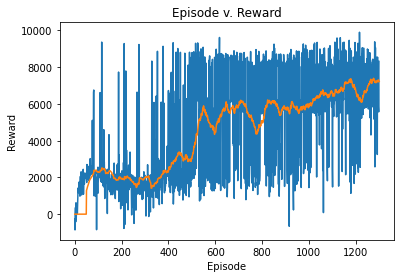

In [ ]:
plt.figure(2)
plt.clf()
plt.title('Episode v. Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
reward = [x for x in episode_rewards] 
episode_rewards_Tensor = torch.tensor(reward, dtype=torch.float)
plt.plot(episode_rewards_Tensor.numpy())
if len(episode_rewards_Tensor) >= 50:
    means = episode_rewards_Tensor.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(50), means))
    plt.plot(means.numpy())

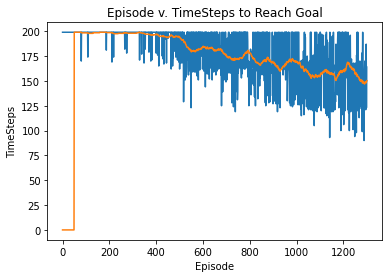

In [ ]:
plt.figure(3)
plt.clf()
plt.title('Episode v. TimeSteps to Reach Goal')
plt.xlabel('Episode')
plt.ylabel('TimeSteps')
timestep_T = [x for x in episodeNum] 
episodeNum_Tensor = torch.tensor(timestep_T, dtype=torch.float)
plt.plot(episodeNum_Tensor.numpy())
if len(episodeNum_Tensor) >= 50:
    means = episodeNum_Tensor.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(50), means))
    plt.plot(means.numpy())